# QligFEP benchmarking

In [1]:
import glob
import os
import itertools
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.DataStructs import FingerprintSimilarity
import numpy as np
import sys
from rdkit.Chem import rdFMCS
import glob
from pathlib import Path

sys.path.insert(0, os.path.abspath(os.path.join((Path(_dh[-1])), '../src/')))

import QmapFEP
from QmapFEP import GenRgroup

datadir = '../data/benchmark/qligfep/'

def MFP_matrix(mol_list):
    fp = [AllChem.GetMorganFingerprintAsBitVect(mol, 2) for mol in mol_list]
    mfps = list(FingerprintSimilarity(x, y) for x, y in itertools.product(fp, repeat=2))
    return fp, np.array(mfps).reshape(len(fp), len(fp))

target_data = {}
target_labels = []
# TO DO: fix path name logic
for sdf in glob.glob('{}/sdf/*.sdf'.format(datadir)):
    target = sdf.split('/')[-1].split('_ligands')[0]
    suppl = Chem.SDMolSupplier(sdf)
    fp_list, fp_mat = MFP_matrix(suppl)
    name_list = [mol.GetProp('_Name') for mol in suppl]
    target_data[target] = {}
    target_data[target]['fp_list'] = fp_list
    target_data[target]['name_list'] = name_list
    target_labels.extend([target] * len(suppl))


fps = [target_data[targ]['fp_list'] for targ in target_data.keys()]
flat_fps =  np.array([fp for target in fps for fp in target])
print(flat_fps)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [38]:
def get_core(suppl):
    # Change to ForwardSDMolSupplier at some point
    res=rdFMCS.FindMCS(suppl).smartsString
    #res=rdFMCS.FindMCS(self.sdf).smartsString
    core = Chem.MolFromSmarts(res)
    #Chem.rdDepictor.Compute2DCoords(core)
    return(res)

In [39]:
# code block to generate MCS figure
MCS_list = []
labels = []
for sdf in glob.glob('../data/benchmark/qligfep/sdf/*.sdf'):
    suppl = Chem.SDMolSupplier(sdf)
    coremol = get_core(suppl)
    MCS_list.append(coremol)
    #_MCS= rdFMCS.FindMCS(suppl)
    #print(_MCS)
    #MCS_smart = Chem.MolFromSmarts(_MCS.smartsString)
    #MCS_list.append(MCS_smart)
    
#Chem.Draw.MolToImage(MCS_list[0])

In [41]:
MCS_list[0]

'[#6]1(:[#6]:[#6](:[#6]:[#6]2:[#6]:1:[#7]:[#6]:[#6]:[#7]:2)-[#7]-[#6](:[#6]):[#6]:[#6]:[#6])-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1'

In [24]:
help(rdFMCS.FindMCS)

Help on built-in function FindMCS in module rdkit.Chem.rdFMCS:

FindMCS(...)
    FindMCS( (AtomPairsParameters)mols [, (bool)maximizeBonds=True [, (float)threshold=1.0 [, (int)timeout=3600 [, (bool)verbose=False [, (bool)matchValences=False [, (bool)ringMatchesRingOnly=False [, (bool)completeRingsOnly=False [, (bool)matchChiralTag=False [, (AtomCompare)atomCompare=rdkit.Chem.rdFMCS.AtomCompare.CompareElements [, (BondCompare)bondCompare=rdkit.Chem.rdFMCS.BondCompare.CompareOrder [, (RingCompare)ringCompare=rdkit.Chem.rdFMCS.RingCompare.IgnoreRingFusion [, (str)seedSmarts='']]]]]]]]]]]]) -> MCSResult :
        Find the MCS for a set of molecules
    
        C++ signature :
            RDKit::MCSResult* FindMCS(boost::python::api::object [,bool=True [,double=1.0 [,unsigned int=3600 [,bool=False [,bool=False [,bool=False [,bool=False [,bool=False [,RDKit::AtomComparator=rdkit.Chem.rdFMCS.AtomCompare.CompareElements [,RDKit::BondComparator=rdkit.Chem.rdFMCS.BondCompare.CompareOrder [,RDKi

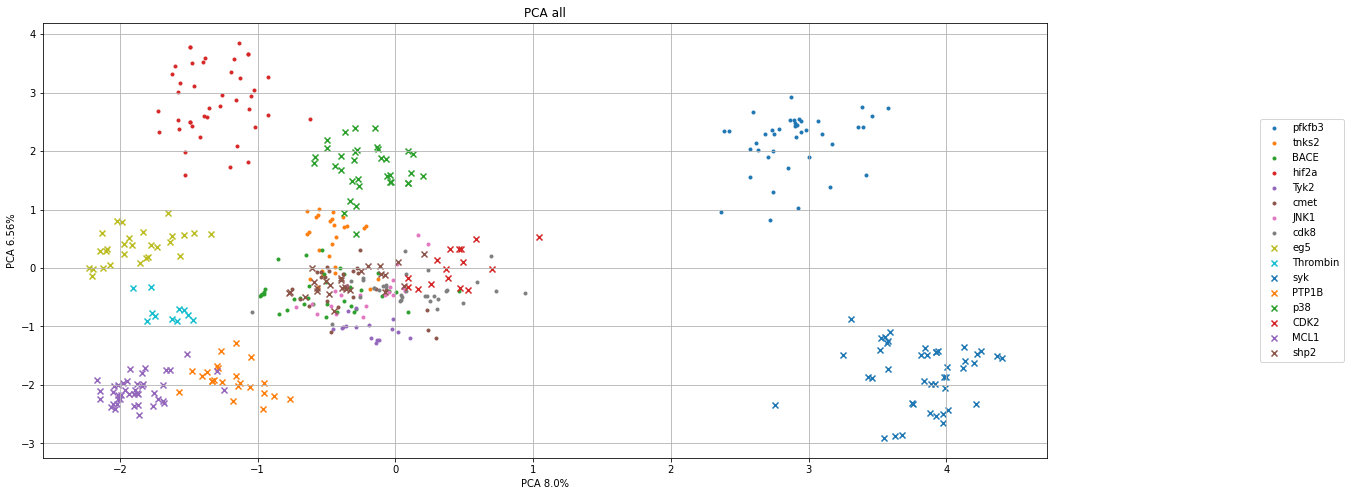

In [3]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.cm as cm
pca = PCA(n_components=2)
pca_coords = pca.fit_transform(flat_fps)
fig = plt.figure(figsize=(18, 8))
X = [i[0] for i in pca_coords] #X axis
Y = [i[1] for i in pca_coords] #Y axis
markers = ['.', 'x']
k = 0
for target in target_data.keys(): #iterate over targets 
    k += 1
    if k <= 8:
        m = markers[0]
    else:
        m = markers[1]
    indices = [i for i, target_label in enumerate(target_labels) if target_label == target]
    targ_x = [X[i] for i in indices]
    targ_y = [Y[i] for i in indices]
    plt.scatter(targ_x, targ_y, label = target, marker=m)
    
plt.legend(loc='right', bbox_to_anchor=(1.3, 0.5))
plt.title('PCA all')
plt.xlabel('PCA {}%'.format(round(pca.explained_variance_ratio_[0]*100, 2)))
plt.ylabel('PCA {}%'.format(round(pca.explained_variance_ratio_[1]*100, 2)))
plt.grid()

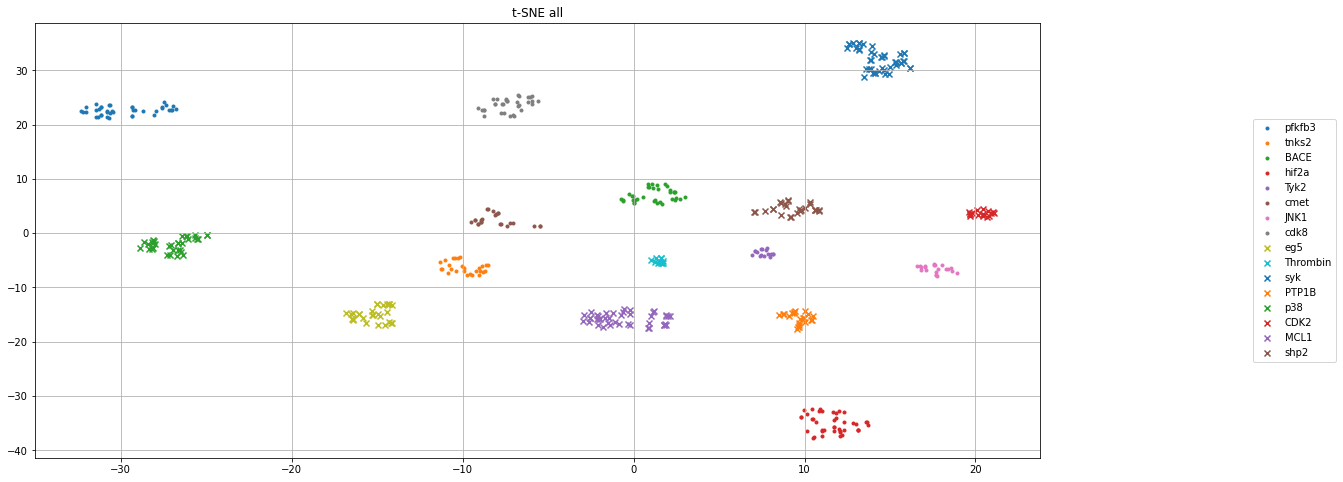

In [4]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
tx = tsne.fit_transform(flat_fps)
fig = plt.figure(figsize=(18, 8))
X = [i[0] for i in tx] #X axis
Y = [i[1] for i in tx] #Y axis
k = 0
for target in target_data.keys(): #iterate over targets 
    k += 1
    if k <= 8:
        m = markers[0]
    else:
        m = markers[1]
    indices = [i for i, target_label in enumerate(target_labels) if target_label == target]
    targ_x = [X[i] for i in indices]
    targ_y = [Y[i] for i in indices]
    plt.scatter(targ_x, targ_y, label = target, marker=m)
    
plt.legend(loc='right', bbox_to_anchor=(1.3, 0.5))
plt.title('t-SNE all')
plt.grid()

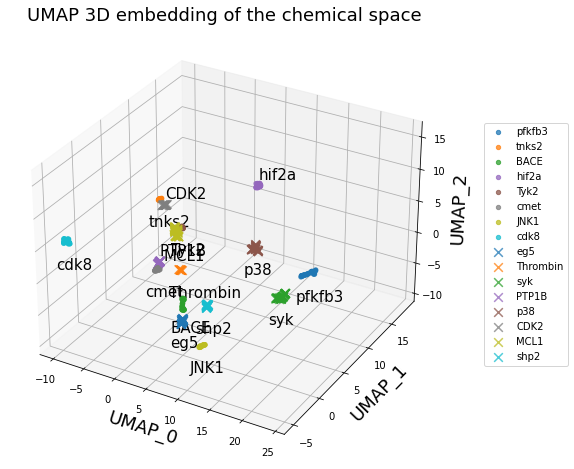

In [5]:
import umap.umap_ as umap
import umap.plot
import matplotlib.cm as cm
fit = umap.UMAP(
        n_neighbors=15,
        min_dist=0.15,
        n_components=3,
        random_state=42
    )
u = fit.fit_transform(flat_fps)
fig = plt.figure(figsize=(18, 8))
ax = fig.add_subplot(111, projection='3d')
X = [i[0] for i in u] #X axis
Y = [i[1] for i in u] #Y axis 
Z = [i[2] for i in u] #Z axis
markers = ['.', 'x']
k = -1
colors = itertools.cycle(cm.tab10(np.linspace(0, 1, 8)))
for target, c in zip(target_data.keys(), colors): #iterate over targets
    k += 1
    if k < 8:
        m = markers[0]
    else:
        m = markers[1]
    indices = [i for i, target_label in enumerate(target_labels) if target_label == target]
    targ_x = [X[i] for i in indices]
    targ_y = [Y[i] for i in indices]
    targ_z = [Z[i] for i in indices]
    ax.scatter(targ_x, targ_y, targ_z, marker=m, s=75, color=c, label=target, alpha=0.75)
    if target in ['PTP1B', 'hif2a', 'CDK2']:
        ax.text(np.mean(targ_x), np.mean(targ_y), np.mean(targ_z) + 1, target, size=15)
    else:   
        ax.text(np.mean(targ_x) - 2, np.mean(targ_y), np.mean(targ_z) - 5, target, size=15)

plt.legend(loc='right', bbox_to_anchor=(1.3, 0.5))
plt.xlabel('UMAP_0', fontsize=18)
plt.ylabel('UMAP_1', fontsize=18)
ax.set_zlabel('UMAP_2', fontsize=18)
plt.title('UMAP 3D embedding of the chemical space', fontsize=18)
plt.savefig('{}/plots/UMAP.svg'.format(datadir), dpi=300)
plt.savefig('{}/plots/UMAP.png'.format(datadir), dpi=300)
plt.show()

## Random Seed uniform distribution.
#### The random seeds where generated with the function $RANDOM which returns a different random integer at each invocation.
#### Nominal range: 0 - 32767 (signed 16-bit integer).

In [6]:
import pandas as pd
summary_dict = {}
seeds = []
for forcefield in ['OPLS2015', 'openFF2', 'openFF']:
    summary_dict[forcefield] = {}
    for file in glob.glob('{}/processed/summary_files/{}/*/*/Summary*'.format(datadir,forcefield)):
        target, leg = file.split('/')[-3], file.split('/')[-2]
        if target not in summary_dict[forcefield].keys():
            summary_dict[forcefield][target] = {'protein':{}, 'water':{}}
        summary_dict[forcefield][target][leg] = pd.read_csv(file)
        seeds.extend(summary_dict[forcefield][target][leg]['seed    '].tolist())
        starting_time = [pd.to_datetime(slice.split()[3]) for slice in summary_dict[forcefield][target][leg]['starting time'].tolist()]
        ending_time = [pd.to_datetime(slice.split()[3]) for slice in summary_dict[forcefield][target][leg]['ending time'].tolist()]
        summary_dict[forcefield][target][leg]['running_time'] = [(x - y) for x, y in zip(ending_time, starting_time)]

In [6]:
#for example
summary_dict['OPLS2015']['CDK2']['protein'].head()

,Replicate no.,seed,server,jobid,starting time,ending time,lambda_energies,running_time
0,1,30242,KEBNE,17018657,Wed Dec 22 00:22:47 CET,Wed Dec 22 02:38:34 CET,0.0 0.317 0.461 0.595 0.73 0.854 0.956 1.053 1...,0 days 02:15:47
1,2,3555,KEBNE,17018658,Wed Dec 22 00:22:46 CET,Wed Dec 22 02:39:33 CET,0.0 0.253 0.414 0.543 0.643 0.743 0.848 0.94 1...,0 days 02:16:47
2,3,17099,KEBNE,17018659,Wed Dec 22 00:22:46 CET,Wed Dec 22 02:39:40 CET,0.0 0.335 0.535 0.674 0.793 0.9 0.999 1.095 1....,0 days 02:16:54
3,4,23826,KEBNE,17018660,Wed Dec 22 00:22:46 CET,Wed Dec 22 02:39:00 CET,0.0 0.344 0.589 0.761 0.885 0.986 1.074 1.161 ...,0 days 02:16:14
4,5,21514,KEBNE,17018661,Wed Dec 22 00:22:47 CET,Wed Dec 22 02:38:16 CET,0.0 0.345 0.513 0.645 0.782 0.913 1.028 1.12 1...,0 days 02:15:29


## Estimation of mean running time for protein and water leg

Protein leg mean ~2.061h
Water leg mean ~1.684h


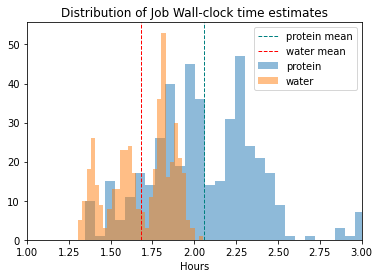

In [7]:
running_time = {}
for leg in ['protein', 'water']:
    running_time[leg] = []
    for forcefield in summary_dict.keys():
        for target in summary_dict[forcefield].keys():
            running_time[leg].extend(summary_dict[forcefield][target][leg]['running_time'].tolist())

    running_time[leg] = [td for td in running_time[leg] if td.seconds >= 3600]        
    running_time[leg] = [td.seconds / 3600 for td in running_time[leg]]

plt.hist(running_time['protein'], bins=30, label='protein', alpha=0.5);
plt.hist(running_time['water'], bins=30, label='water', alpha=0.5);
plt.axvline(np.mean(running_time['protein']), color='teal', linestyle='dashed', linewidth=1, label='protein mean');
plt.axvline(np.mean(running_time['water']), color='red', linestyle='dashed', linewidth=1, label='water mean');
plt.xlabel('Hours')
plt.xlim(1, 3);
plt.title('Distribution of Job Wall-clock time estimates')
plt.legend()
print('Protein leg mean ~{:.3f}h'.format(np.mean(running_time['protein'])))
print('Water leg mean ~{:.3f}h'.format(np.mean(running_time['water'])))

## Estimation of mean standard error of the means for protein and water leg

Protein leg mean ~0.378 (kcal/mol)
Water leg mean ~0.263 (kcal/mol)


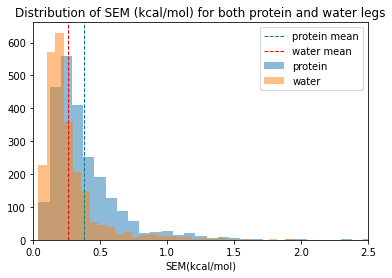

In [8]:
sems = {}
for leg in ['protein', 'water']:
    sems[leg] = []
    for forcefield in summary_dict.keys():
        for target in summary_dict[forcefield].keys():
            if target in ['cdk8', 'cmet', 'eg5', 'hif2a', 'pfkfb3', 'shp2', 'syk', 'tnks2']:
                benchmark = 'Merck'
            else:
                benchmark = 'JACS'
                
            tarfile = glob.glob('{}/raw/{}/{}/*{}/benchmark/2fs/{}*.txt'.format(datadir, benchmark, forcefield, target, leg))[0]
            with open(tarfile, 'r') as infile:
                for line in infile:
                    line = line.split()
                    if line[0] == 'FEP':
                        continue
                    else:
                        if 'nan' == line[2]:
                            continue
                        else:
                            sems[leg].append(float(line[2]))

plt.hist(sems['protein'], bins=30, label='protein', alpha=0.5);
plt.hist(sems['water'], bins=30, label='water', alpha=0.5);
plt.axvline(np.mean(sems['protein']), color='teal', linestyle='dashed', linewidth=1, label='protein mean');
plt.axvline(np.mean(sems['water']), color='red', linestyle='dashed', linewidth=1, label='water mean');
plt.xlabel('SEM(kcal/mol)')
plt.xlim(0.0, 2.5);
plt.title('Distribution of SEM (kcal/mol) for both protein and water legs')
plt.legend()
print('Protein leg mean ~{:.3f} (kcal/mol)'.format(np.mean(sems['protein'])))
print('Water leg mean ~{:.3f} (kcal/mol)'.format(np.mean(sems['water'])))

Text(0.5, 1.0, 'Uniform distribution of random seeds')

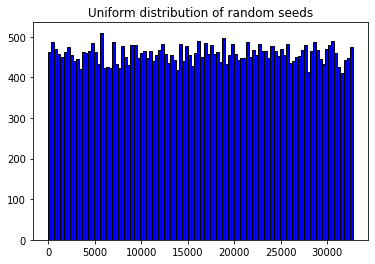

In [9]:
import matplotlib.pyplot as plt
plt.hist(seeds, color = 'blue', edgecolor = 'black', bins = 100);
plt.title('Uniform distribution of random seeds')

??????

 # Plots

In [11]:
import pandas as pd

## WHAT IS HAPPENING HERE???
#results_dir = os.getcwd() + '/results/old_results'
#results_dir = os.getcwd() + '/results/new_results'
results_dir = os.getcwd() + '/{}/processed/new_results_2'.format(datadir)
#results_dir = os.getcwd() + '/results/merged_results'

results = {}
for benchmark in ['JACS', 'Merck']:
    results[benchmark] = {}
    targets = glob.glob('{}/{}/*'.format(results_dir, benchmark))
    for target in targets:
        name = target.split('/')[-1]
        results[benchmark][name] = {}
        for method in ['FEP+_5ns', 'openFF', 'openFF2', 'OPLS2015']:
            results[benchmark][name][method] = {'ddG':{}, 'dG':{}}
            r = results[benchmark][name][method]
            r['ddG'] = pd.read_csv('{}/{}/{}_ddG.csv'.format(target, method, name))
            r['ddG']['error'] = r['ddG']['Exp. ddG'] - r['ddG']['Pred. ddG']
            r['dG'] = pd.read_csv('{}/{}/{}_dG.csv'.format(target, method, name))


In [13]:

for target in ['Tyk2', 'p38', 'JNK1', 'CDK2', 'PTP1B', 'MCL1', 'Thrombin', 'BACE']:
    for method in ['cresset_valid', 'amber', 'gaff', 'cgenff', 'consensus']:
        results['JACS'][target][method] = {'ddG':{}, 'dG':{}}
        name = target
        df = pd.read_excel('{}/processed/final_results_all.xlsx'.format(datadir), 
                            engine='openpyxl', sheet_name='{}'.format(name))
        df = df[['#Ligand', 'dGexptl', '{}'.format(method)]]
        df.rename(columns={'#Ligand': 'Ligand', 'dGexptl': 'Exp. dG', '{}'.format(method):'Pred. dG'}, inplace=True)
        df['CCC_Error'] = 0
        results['JACS'][target][method]['dG'] = df.iloc[:-1, :]

Bellow snippet needs to be put in analysis module

In [21]:
from scipy import stats
from sklearn.utils import resample
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import matthews_corrcoef

def pearsonr_ci(x, y, alpha=0.05):
    ''' calculate Pearson correlation along with the confidence interval using scipy and numpy
    Parameters
    ----------
    x, y : iterable object such as a list or np.array
    Input for correlation calculation
    alpha : float
    Significance level. 0.05 by default
    Returns
    -------
    r : float
    Pearson's correlation coefficient
    pval : float
    The corresponding p value
    lo, hi : float
    The lower and upper bound of confidence intervals
    '''

    x = np.array(x)
    y = np.array(y)
    r, p = stats.pearsonr(x, y)
    r_z = np.arctanh(r)
    se = 1 / np.sqrt(x.size - 3)
    z = stats.norm.ppf(1 - alpha / 2)
    lo_z, hi_z = r_z - z * se, r_z + z * se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi

def rmse(targets, predictions):
    'calculate root mean square error between array of targets and predictions'
    return np.sqrt(((np.array(predictions) - np.array(targets)) ** 2).mean())

def analysis(X, Y, Z):
    'Returns statistics for correlation between arrays of targets and predictions'
    X = [float(x) for x in X]
    Y = [float(x) for x in Y]
    Z = [float(x) for x in Z]
    n_size = int(len(X) * 0.95)
    bstp = {'MCC': [], 'MAE': [], 'RMSE': [], 'k_tau': [], 'r':[], 'r2': [], 'lo': [], 'hi': [], 'p_value': [], 'SEM': []}
    data = np.column_stack((X, Y, Z))
    n = len(X)
    if n > 2:
        slope, intercept, _, p_value, std_err = stats.linregress(X, Y)
        regr = [(slope * x + intercept) for x in X]
        rho, _ = stats.spearmanr(X, Y)
        for i in range(100):
            sampl = resample(data, n_samples=n_size, random_state=i)
            X = [i[0] for i in sampl]
            Y = [i[1] for i in sampl]
            Z = [i[2] for i in sampl]
            X2 = np.sign(X)
            Y2 = np.sign(Y)
            if all(i < 0 for i in X2) and all(j < 0 for j in Y2):
                MCC = 0.0
            else:
                bstp['MCC'].append(matthews_corrcoef(X2, Y2))
            bstp['MAE'].append(mean_absolute_error(X, Y))
            bstp['RMSE'].append(rmse(X, Y))
            bstp['k_tau'].append(stats.kendalltau(X, Y)[0])
            bstp['p_value'].append(stats.kendalltau(X, Y)[1])
            r, _, lo, hi = pearsonr_ci(X, Y)
            bstp['lo'].append(lo**2)
            bstp['hi'].append(hi**2)
            bstp['r'].append(r)
            bstp['r2'].append(r**2)
            bstp['SEM'].append(np.mean(Z))
    
        metrics = {'MCC': [], 'MAE': [], 'RMSE': [], 'sp_rho': rho, 'k_tau': [], 'r':[], 'r2': [], 'lo': [], 'hi': [], 'p_value': [], 'slope': slope, 'intercept': intercept, "n": n, "reg": regr, 'SEM': []}
        for k, v in bstp.items():
            metrics[k].append(round(np.mean(v), 2))
            metrics[k].append(round(np.std(v), 2))
        
        for k, v in metrics.items():
            try:
                metrics[k] = round(v, 2)
            except TypeError:
                continue
        return metrics

def linplot(include, d, method, storedir):
    targs = []
    preds = []
    sems = []
    k = 0
    markers = ['s', 'o']
    fig, ax = plt.subplots(nrows=1, ncols=2, gridspec_kw={'width_ratios': [4, 1]}, figsize=(12,10), facecolor='white')
    ax[1].axis('off')
    if d == 'ddG':
        type = 'relat'
        ax[0].set_xlim(-8, 8)
        ax[0].set_ylim(-8, 8)
        ax[0].plot((-8, 8), (-8, 8), color='black')
        ax[0].plot((-8, 7), (-7, 8), color='black', linestyle='--', alpha=0.7)
        ax[0].plot((-7, 8), (-8, 7), color='black', linestyle='--', alpha=0.7)
        ax[0].plot((-8, 6), (-6, 8), color='black', linestyle='-.', alpha=0.7)
        ax[0].plot((-6, 8), (-8, 6), color='black', linestyle='-.', alpha=0.7)
    elif d == 'dG':
        type = 'abs'
        ax[0].set_xlim(-16, -2)
        ax[0].set_ylim(-16, -2)
        ax[0].plot((-18, 0), (-18, 0), color='black')
        ax[0].plot((-18, -2), (-17, -1), color='black', linestyle='--', alpha=0.7)
        ax[0].plot((-17, -1), (-18, -2), color='black', linestyle='--', alpha=0.7)
        ax[0].plot((-18, -3), (-16, -1), color='black', linestyle='-.', alpha=0.7)
        ax[0].plot((-16, -1), (-18, -3), color='black', linestyle='-.', alpha=0.7)
    ax[0].set_xlabel('{} exp [$kcal mol^{}$]'.format(d, -1), fontsize=24)
    ax[0].set_ylabel('{} pred [$kcal mol^{}$]'.format(d, -1), fontsize=24)
    ax[0].tick_params(axis='both', which='major', labelsize=16)
    with open('{}/{}_{}_linplot_data.txt'.format(storedir, d, method), 'w') as outfile:
        if type == 'relat':
            outfile.write('{},{},{},{},{}\n'.format('Ligand_1', 'Ligand_2', 'Pred. ddG', 'Exp. ddG', 'CCC error'))
        else:
            outfile.write('{},{},{},{}\n'.format('Ligand', 'Pred. dG', 'Exp. dG', 'CCC path error'))
        for benchmark in results.keys():
            for target in results[benchmark].keys():
                if include == ['All']:
                    pass
                elif target in include:
                    pass
                else:
                    continue
                k += 1
                if (k % 2) == 0:
                    m = markers[0]
                else:
                    m = markers[1]
                rd = results[benchmark][target][method][d]
                targs.append(rd['Exp. {}'.format(d)])
                preds.append(rd['Pred. {}'.format(d)])
                try:
                    sems.append(rd['CCC_Error'])
                    error = 'CCC_Error'
                except:
                    sems.append(rd['SEM'])
                    error = 'SEM'
                if type == 'relat':
                    ieb = ax[0].errorbar(x=rd['Exp. {}'.format(d)], y=rd['Pred. {}'.format(d)], yerr=rd[error], fmt='o', ecolor='grey', marker=m, alpha=0.20)
                im = ax[0].scatter(x=rd['Exp. {}'.format(d)], y=rd['Pred. {}'.format(d)], edgecolors='black', s=75, marker=m, label=target)
                if type == 'relat':
                    for _, r in rd.iterrows():
                        outfile.write('{},{},{},{},{}\n'.format(r['Ligand_1'], r['Ligand_2'], round(r['Pred. ddG'], 3), r['Exp. ddG'], round(r['SEM'], 3)))
                else:
                    for _, r in rd.iterrows():
                        outfile.write('{},{},{},{}\n'.format(r['Ligand'], round(r['Pred. dG'], 3), r['Exp. dG'], round(r['CCC_Error'], 3)))
    
    targs =  [i for target in targs for i in target]
    preds =  [i for target in preds for i in target]
    sems =  [i for target in sems for i in target]
    
    ban_idx = []
    for arr in [targs, preds, sems]:
        nan_idx = [x for x in range(0, len(arr)) if np.isnan(arr[x])]
        ban_idx.extend(nan_idx)
        
    targs = [j for i, j in enumerate(targs) if i not in ban_idx]
    preds = [j for i, j in enumerate(preds) if i not in ban_idx]
    sems = [j for i, j in enumerate(sems) if i not in ban_idx]
    m = analysis(targs, preds, sems)
    reg = [m['slope'] * x + m['intercept'] for x in np.arange(-18, 9, 1)]
    ax[0].plot(np.arange(-18, 9, 1), reg, color='orange', linewidth=3)

    if type == 'abs':
        ax[1].annotate('y={}\n +{}*x\nR$^2$={}±{}\nR={}±{}\nN={}\n\u03C1={}\n\u03C4={}±{}\nMAE={}±{}\nRMSE={}±{}\nPath_error={}±{}'.format(m["intercept"],
        m["slope"], m["r2"][0], m["r2"][1], m["r"][0], m["r"][1], m["n"], m["sp_rho"], m["k_tau"][0], m["k_tau"][1], m["MAE"][0], m['MAE'][1], m["RMSE"][0], m["RMSE"][1], m["SEM"][0], m["SEM"][1]), xy=(0, 0.25), size=22, bbox=dict(boxstyle="round", fc=(0.8, 0.6, 0.2)))
    if type == 'relat':
        ax[1].annotate('y={}\n +{}*x\nR$^2$={}±{}\nR={}±{}\nN={}\n\u03C1={}\n\u03C4={}±{}\nMAE={}±{}\nRMSE={}±{}\nMCC={}±{}\nCCC_error={}±{}'.format(m["intercept"],
        m["slope"], m["r2"][0], m["r2"][1], m["r"][0], m["r"][1], m["n"], m["sp_rho"], m["k_tau"][0], m["k_tau"][1],
        m["MAE"][0], m['MAE'][1], m["RMSE"][0], m["RMSE"][1], m["MCC"][0], m["MCC"][1],
        m["SEM"][0], m["SEM"][1]), xy=(0, 0.125), size=22, bbox=dict(boxstyle="round", fc=(0.8, 0.6, 0.2)))
    ax[0].legend(loc=4)
    ax[0].grid(alpha=0.3)
    plt.savefig('{}/linreg_{}_{}.png'.format(storedir, d, method), dpi=300)
    plt.show()


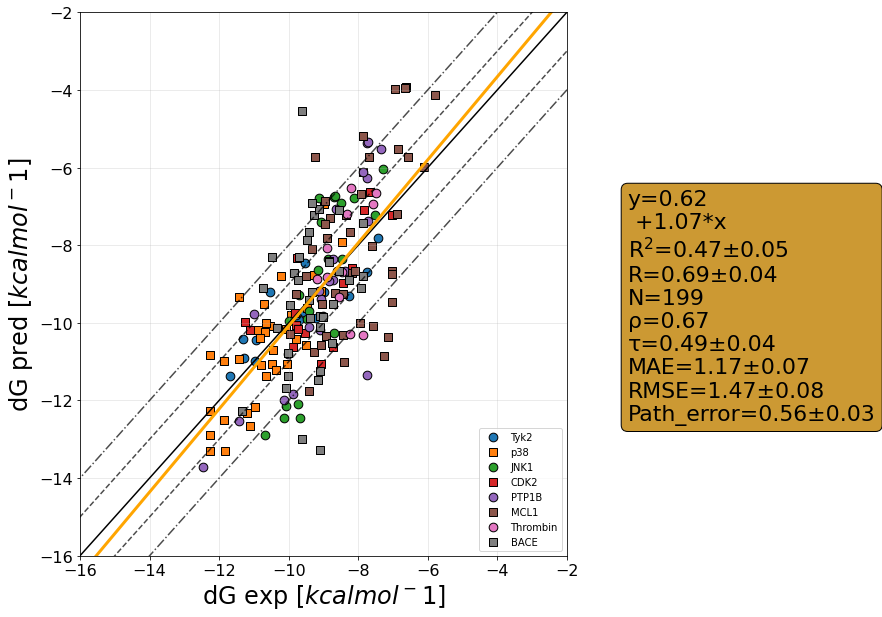

In [26]:
#in method you can try: 'cresset_valid', 'amber', 'gaff', 'cgenff', 'consensus', FEP+_5ns
# also
# 'OPLS2015', openFF', 'openFF2' (QligFEP)

#Merck -> #'cdk8', 'cmet', 'eg5', 'hif2a', 'pfkfb3', 'shp2', 'syk', 'tnks2'
#JACS -> #'BACE', 'CDK2', 'JNK1', 'MCL1', 'PTP1B', 'Thrombin', 'Tyk2', 'p38'

import warnings
plotdir = '{}/plots/'.format(datadir)
warnings.filterwarnings('ignore')
linplot(include=['BACE', 'CDK2', 'JNK1', 'MCL1', 'PTP1B', 'Thrombin', 'Tyk2', 'p38'], d='dG', method='OPLS2015', storedir=plotdir)

# Tables/Barplots

Also needs to go in function

In [33]:
def barplot(d, metric):
    c = plt.cm.Set1(np.linspace(0,1,8))
    fig = plt.figure(figsize=(24, 8), facecolor='white')
    axes = fig.subplots(nrows=2, ncols=8)
    #fig.suptitle('JACS & Merck benchmarks - QligFEP {} results'.format(d), size=24)
    performance = []

    with open('{}/plots/{}_{}_barplot_data.txt'.format(datadir, d, metric), 'w') as outfile:
        for i, target in enumerate(['BACE', 'CDK2', 'JNK1', 'MCL1', 'PTP1B', 'Thrombin', 'Tyk2', 'p38', 'CDK8', 'cMET', 'EG5', 'HIF2A', 'PFKFB3', 'SHP2', 'SYK', 'TNKS2']):
            if i < 8:
                benchmark = 'JACS'
                y = 0
            else:
                benchmark = 'Merck'
                y = 1
            means = []
            stdev = []
            for method in ['OPLS2015', 'openFF', 'openFF2', 'FEP+_5ns']:
                try:
                    r = results[benchmark][target][method][d]    
                except:
                    r = results[benchmark][target.lower()][method][d]    
                if i >= 8:
                    i = i - 8
                try:
                    m = analysis(r['Exp. {}'.format(d)], r['Pred. {}'.format(d)], r['CCC_Error'])
                except:
                    m = analysis(r['Exp. {}'.format(d)], r['Pred. {}'.format(d)], r['SEM'])
                if method == 'OPLS2015':
                    performance.append((m[metric][0], m[metric][1], target))
                means.append(m[metric][0])
                stdev.append(m[metric][1])
                outfile.write('{} - {} - {}±{}\n'.format(method, target, m[metric][0], m[metric][1]))
            title = target
            axes[y, i].bar([0, 1, 2, 3], means, yerr=stdev, color=c, zorder=3, capsize=5, width=1.0, edgecolor='black')
            
            axes[y, i].set_title(title)
            axes[y, i].set_ylim(0, 2.5)
            axes[y, i].set_yticks(np.arange(0.5, 2.5, 0.5))
            axes[y, i].set_xticks([])
            axes[y, i].grid(zorder=0)
    
    from matplotlib.lines import Line2D
    #fig.text(0.075, 0.25, 'RMSE (kcal/mol)', rotation='vertical', size=30)
    legend_elements = [Line2D([0], [0], color=c[0], lw=7, label='OPLS2015'),
                        Line2D([0], [0], color=c[1], lw=7, label='openFF'),
                        Line2D([0], [0], color=c[2], lw=7, label='openFF2'),
                        Line2D([0], [0], color=c[3], lw=7, label='FEP+_5ns')]
    fig.legend(handles=legend_elements,
            labels=['OPLS2015', 'openFF', 'openFF2', 'OPLS2.1/OPLS3e'],   # The labels for each line
            loc="right",   # Position of legend
            title="Forcefield", # Title for the legend
            fontsize=12.5
            ) 
    plt.savefig('{}/plots/Barplots_{}.png'.format(datadir,d), dpi=1000)
    plt.show()
    return performance

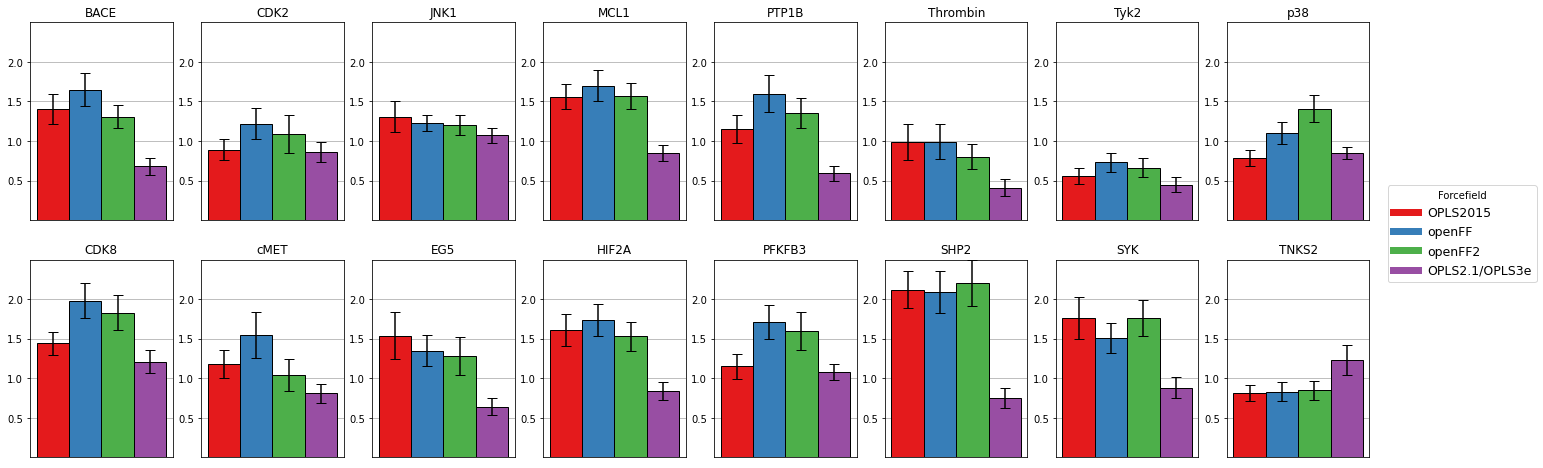

Average mean 1.0789207142857145 and standard deviation 0.11718794010311918


In [34]:
performance = barplot(d='dG', metric='MAE')

#If you want to recalculate with bootstrapping the overall performance for the 
# a desired metric

performance = performance[:8] #JACS only
#performance = performance[1:3] + performance[4:8] #Excluding BACE and MCL1
#performance = performance[8:] #Merck only
#performance = performance #All together

import random
means = []
for i in np.arange(10000):
    sample = random.choices(performance, k=round(len(performance)*0.90))
    means.append(np.mean([x for x, y, z in sample]))
    
print('Average mean {} and standard deviation {}'.format(np.mean(means), np.std(means)))

In [39]:
def get_results(metric, method, dataset):
    performance = []
    if dataset == 'All':
        #cresset_valid schrodinger	amber	gaff	cgenff	consensus
        for target in ['BACE', 'CDK2', 'JNK1', 'MCL1', 'PTP1B', 'Thrombin', 'Tyk2', 'p38']:   
            dt = pd.read_excel('{}/processed/final_results_all.xlsx'.format(datadir), engine='openpyxl', sheet_name='{}'.format(target))
            m = analysis(dt['dGexptl'][:-1], dt[method][:-1], np.zeros(len(dt['dGexptl']) - 1))
            performance.append((m[metric][0], m[metric][1], target))
    else:
        dt = pd.read_excel('{}/processed/final_results_all.xlsx'.format(datadir), engine='openpyxl', sheet_name='{}'.format(dataset))
        m = analysis(dt['dGexptl'][:-1], dt[method][:-1], np.zeros(len(dt['dGexptl']) - 1))
        performance.append((m[metric][0], m[metric][1], dataset))
    return performance

In [40]:
#If you want to calculate the dG metrics for any of the following 'methods'
# cresset_valid schrodinger	amber	gaff	cgenff	consensus with bootstrapping
import random
performance = get_results('MAE', 'consensus', 'All')
means = []
for i in np.arange(10000):
    sample = random.choices(performance[:8], k=round(len(performance[:8])*0.90))
    means.append(np.mean([x for x, y, z in sample]))
    
print('Average mean {} and standard deviation {}'.format(np.mean(means), np.std(means)))

Average mean 0.7165274285714286 and standard deviation 0.06597385399488781


### Select random perturbations with low error, where QligFEP is able to capture both the right direction and magnitude. Might be useful for choosing perturbations for the figures of the manuscript.

In [41]:
ff = 'OPLS2015'
low_error = []
for benchmark in results.keys():
    for target in results[benchmark].keys():
        r = results[benchmark][target][ff]['ddG']
        r['target'] = target
        r['benchmark'] = benchmark
        low_error.append(r[r['error'].between(-1,1)])

low_error_perturbations = pd.concat(low_error)

In [42]:
low_error_perturbations.query('-1 < error < 1 & benchmark == "JACS"').sample(n = 5)

,Ligand_1,Ligand_2,Exp. ddG,Pred. ddG,SEM,STD,crashes,error,target,benchmark
10,18628-1,18625-1,0.59,-0.013,0.064,1.2823,0,0.603,JNK1,JACS
24,ejm-43,ejm-55,-0.95,-0.556,0.387,1.0294,0,-0.394,Tyk2,JACS
7,20670-2qbs-,23475,0.36,0.504,0.225,0.8964,0,-0.144,PTP1B,JACS
1,27,32,-0.46,0.249,0.179,0.7218,0,-0.709,MCL1,JACS
27,p38a-2r,p38a-2n,-1.06,-1.426,0.502,1.2567,2,0.366,p38,JACS


In [43]:
low_error_perturbations.query('-1 < error < 1 & benchmark == "Merck"').sample(n = 5)

,Ligand_1,Ligand_2,Exp. ddG,Pred. ddG,SEM,STD,crashes,error,target,benchmark
20,252,336,-0.11,0.090,0.081,0.5131,0,-0.200,hif2a,Merck
46,CHEMBL3265015,CHEMBL3265011,0.84,0.707,0.035,1.4743,0,0.133,syk,Merck
17,5l,5f,-0.17,0.379,0.157,0.5025,0,-0.549,tnks2,Merck
30,8f,8e,1.57,1.070,0.660,0.6798,0,0.500,tnks2,Merck
41,CHEMBL1085692,CHEMBL1096003,-0.55,0.004,0.825,2.5924,0,-0.554,eg5,Merck
